In [2]:
import torch
from torch import nn

In [3]:
import torchaudio
import torchaudio.functional as F
import torchaudio.transforms as T

print(torch.__version__)
print(torchaudio.__version__)

1.8.1
0.8.0a0+e4e171a


In [4]:
input_filepath = './diodeclip-input.wav'
target_filepath = './diodeclip-target.wav'
input_waveform, sample_rate = torchaudio.load(input_filepath)
target_waveform, sample_rate = torchaudio.load(target_filepath)

In [7]:
from audio_utils import play_audio, plot_waveform, print_stats, print_metadata, plot_specgram

for filepath in [input_filepath, target_filepath]:
    metadata = torchaudio.info(filepath)
    print_metadata(metadata, src=filepath)
    waveform, _ = torchaudio.load(filepath)
    print_stats(waveform)

----------
Source: ./diodeclip-input.wav
----------
 - sample_rate: 44100
 - num_channels: 1
 - num_frames: 21123903
 - bits_per_sample: 16
 - encoding: PCM_S

Shape: (1, 21123903)
Dtype: torch.float32
 - Max:      0.563
 - Min:     -0.566
 - Mean:    -0.000
 - Std Dev:  0.074

tensor([[-3.0518e-05, -3.0518e-05, -3.0518e-05,  ..., -1.2207e-04,
          9.1553e-05, -1.2207e-04]])

----------
Source: ./diodeclip-target.wav
----------
 - sample_rate: 44100
 - num_channels: 1
 - num_frames: 21123903
 - bits_per_sample: 16
 - encoding: PCM_S

Shape: (1, 21123903)
Dtype: torch.float32
 - Max:      1.000
 - Min:     -1.000
 - Mean:    -0.007
 - Std Dev:  0.719

tensor([[-0.0013, -0.0014, -0.0013,  ..., -0.0008, -0.0002, -0.0011]])



In [8]:
import numpy as np

assert input_waveform.shape == target_waveform.shape
frames_count = input_waveform.shape[1]
train_frames_count = int(0.8 * frames_count)
train_input_waveform = input_waveform[0, :train_frames_count]
# test_input_waveform = input_waveform[0, train_frames_count:]
train_target_waveform = target_waveform[0, :train_frames_count]
# test_target_waveform = target_waveform[0, train_frames_count:]
# torchaudio.save('./test_target.wav', test_target_waveform.unsqueeze(0), sample_rate)
# torchaudio.save('./test_input.wav', test_input_waveform.unsqueeze(0), sample_rate)
test_input_waveform, _ = torchaudio.load('./test_input.wav')
test_target_waveform, _ = torchaudio.load('./test_target.wav')
test_input_waveform.squeeze_(0)
test_target_waveform.squeeze_(0)

tensor([-0.0006, -0.0011, -0.0008,  ..., -0.0008, -0.0002, -0.0011])

In [9]:
class StateTrajectoryNetworkFF(nn.Module):
    def __init__(self, is_trained=False):
        super().__init__()
        self.densely_connected_layers = nn.Sequential(nn.Linear(2, 8, bias=False), nn.Tanh(), nn.Linear(8, 8, bias=False), nn.Tanh(), nn.Linear(8, 1, bias=False))

    def forward(self, x):
        dense_output = self.densely_connected_layers(x)
        output = dense_output[..., 0] + x[..., 1]
        return output.unsqueeze(-1)

stn = StateTrajectoryNetworkFF(is_trained=True)

In [10]:
class StateTrajectoryNetwork(nn.Module):
    def __init__(self, is_trained=False):
        super().__init__()
        self.densely_connected_layers = nn.Sequential(nn.Linear(2, 8, bias=False), nn.Tanh(), nn.Linear(8, 8, bias=False), nn.Tanh(), nn.Linear(8, 1, bias=False))

    def forward(self, x):
        output = torch.zeros_like(x)
        
        for i in range(x.shape[1]):
            dense_output = self.densely_connected_layers(x)
            output = dense_output[..., 0] + x[..., 1]
        return output.unsqueeze(-1)

    def initialize_state(self, batch_size, state_size):
        self.state = torch.zeros((batch_size, state_size))

# stn = StateTrajectoryNetwork()

In [11]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f'Using {device} for training.')

stn.to(device)

Using cuda:0 for training.


StateTrajectoryNetworkFF(
  (densely_connected_layers): Sequential(
    (0): Linear(in_features=2, out_features=8, bias=False)
    (1): Tanh()
    (2): Linear(in_features=8, out_features=8, bias=False)
    (3): Tanh()
    (4): Linear(in_features=8, out_features=1, bias=False)
  )
)

In [12]:
import torch.optim as optim

def normalized_mse_loss(output, target):
    minimum_value = 1e-5 * torch.ones_like(target)
    loss = torch.mean(torch.div((target - output) ** 2, torch.maximum(target ** 2, minimum_value)))
    return loss

optimizer = optim.Adam(stn.parameters(), lr=0.001)
criterion = normalized_mse_loss
# criterion = nn.MSELoss()

In [13]:
print(stn)
for param in stn.parameters():
    print(type(param), param.size())

StateTrajectoryNetworkFF(
  (densely_connected_layers): Sequential(
    (0): Linear(in_features=2, out_features=8, bias=False)
    (1): Tanh()
    (2): Linear(in_features=8, out_features=8, bias=False)
    (3): Tanh()
    (4): Linear(in_features=8, out_features=1, bias=False)
  )
)
<class 'torch.nn.parameter.Parameter'> torch.Size([8, 2])
<class 'torch.nn.parameter.Parameter'> torch.Size([8, 8])
<class 'torch.nn.parameter.Parameter'> torch.Size([1, 8])


In [14]:
# Data pre-processing
sequence_length = 2048
segments_count = train_frames_count // sequence_length
input_batch = np.zeros((segments_count, sequence_length, 2))
target_batch = np.zeros((segments_count, sequence_length, 1))
for i in range(segments_count):
    start_id = i * sequence_length
    end_id = (i + 1) * sequence_length
    input_batch[i, :, 0] = train_input_waveform[start_id:end_id]
    input_batch[i, 1:, 1] = train_target_waveform[start_id:end_id-1]
    target_batch[i, :, 0] = train_target_waveform[start_id:end_id]

print(f'1 input minibatch shape: {input_batch.shape}')
print(f'1 target minibatch shape: {target_batch.shape}')

input_batch = torch.tensor(input_batch, dtype=torch.float, device=device)
target_batch = torch.tensor(target_batch, dtype=torch.float, device=device)

1 input minibatch shape: (8251, 2048, 2)
1 target minibatch shape: (8251, 2048, 1)


In [15]:
# Training
epochs = 200
print_loss_every = 200
segments_in_a_batch = 40
batch_count = segments_count // segments_in_a_batch

loss_history = torch.zeros((epochs,), device=device)
gradient_norm_history = torch.zeros((epochs,), device=device)

for epoch in range(epochs):
    
    running_loss = 0.0

    for i in range(batch_count):
        input_minibatch = input_batch[i*segments_in_a_batch:(i+1)*segments_in_a_batch, :, :]
        target_minibatch = target_batch[i*segments_in_a_batch:(i+1)*segments_in_a_batch, :, :]
        
        optimizer.zero_grad()

        output_minibatch = stn(input_minibatch)

        loss = criterion(output_minibatch, target_minibatch)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        if i % print_loss_every == print_loss_every - 1:
            print('[%d, %5d] loss: %.5f; Running loss: %.5f' % (epoch + 1, i + 1, loss.item(), running_loss/print_loss_every))
            running_loss = 0.
        
    loss_history[epoch] = loss.item()
    gradient = torch.cat([param.grad.flatten() for param in stn.parameters()])
    gradient_norm_history[epoch] = torch.linalg.norm(gradient)

print('Finished training.')

[1,   200] loss: 0.55354; Running loss: 0.78305
[2,   200] loss: 0.49549; Running loss: 0.55924
[3,   200] loss: 0.41090; Running loss: 0.49677
[4,   200] loss: 0.31609; Running loss: 0.40077
[5,   200] loss: 0.28525; Running loss: 0.30484
[6,   200] loss: 0.30121; Running loss: 0.26342
[7,   200] loss: 0.30516; Running loss: 0.25302
[8,   200] loss: 0.29446; Running loss: 0.24420
[9,   200] loss: 0.27457; Running loss: 0.23120
[10,   200] loss: 0.24632; Running loss: 0.21280
[11,   200] loss: 0.20991; Running loss: 0.18838
[12,   200] loss: 0.16745; Running loss: 0.15880
[13,   200] loss: 0.12382; Running loss: 0.12717
[14,   200] loss: 0.08519; Running loss: 0.09808
[15,   200] loss: 0.05550; Running loss: 0.07524
[16,   200] loss: 0.03529; Running loss: 0.05957
[17,   200] loss: 0.02287; Running loss: 0.04969
[18,   200] loss: 0.01581; Running loss: 0.04357
[19,   200] loss: 0.01205; Running loss: 0.03964
[20,   200] loss: 0.01023; Running loss: 0.03698
[21,   200] loss: 0.00952; Ru

Text(0, 0.5, 'Gradient L2 norm')

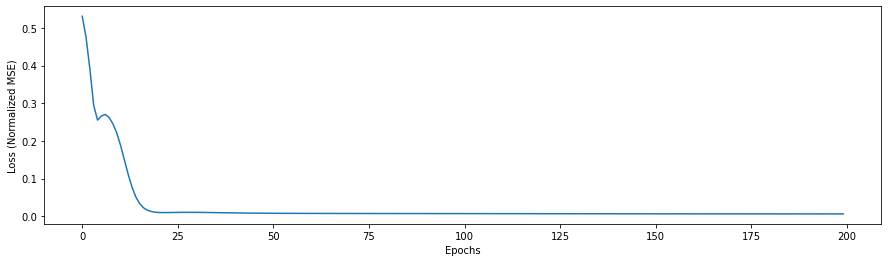

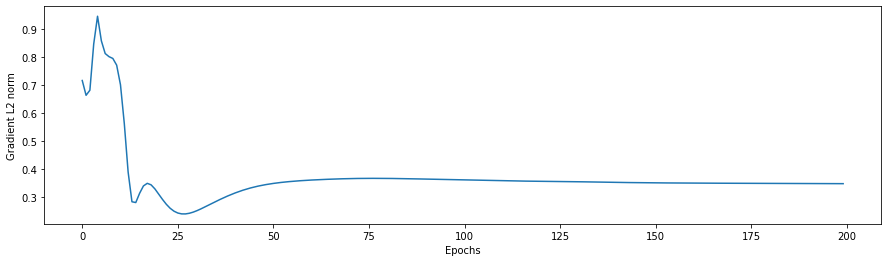

In [16]:
import matplotlib.pyplot as plt

plt.figure()
plt.plot(loss_history.cpu())
plt.xlabel('Epochs')
plt.ylabel('Loss (Normalized MSE)')

plt.figure()
plt.plot(gradient_norm_history.cpu())
plt.xlabel('Epochs')
plt.ylabel('Gradient L2 norm')

In [17]:
PATH = './diode_clipper_2x8tanhRNN.pth'

In [18]:
torch.save(stn.state_dict(), PATH)

In [19]:
stn.load_state_dict(torch.load(PATH))

<All keys matched successfully>

In [21]:
from tqdm import tqdm

# 1 batch, 1-element sequence, 2 variables (input and state, i.e., previous output)
stn = stn.cpu()
input_vector = torch.zeros((1, 1, 2), dtype=torch.float)
output_vector = torch.zeros((1, 1, 1), dtype=torch.float)
test_output = torch.zeros_like(test_input_waveform.to('cpu'))

print('Processing test data...')

with torch.no_grad():
    for i, sample in tqdm(enumerate(test_input_waveform), total=test_input_waveform.shape[0]):
        input_vector[0, 0, 0] = sample
        input_vector[0, 0, 1] = output_vector[0, 0, 0]

        output_vector = stn(input_vector)

        test_output[i] = output_vector[0, 0, 0]

    test_loss = criterion(test_output, test_target_waveform)
    print(f'Test loss: {test_loss:.5f}')

Processing test data...
100%|██████████| 3955706/3955706 [07:12<00:00, 9155.82it/s]Test loss: 0.12799



In [22]:
print_stats(test_output.unsqueeze(0))
test_output = torch.clamp(test_output, -1., 1.)
print_stats(test_output.unsqueeze(0))
torchaudio.save('./test_output.wav', test_output.unsqueeze(0), sample_rate)

Shape: (1, 3955706)
Dtype: torch.float32
 - Max:      2.454
 - Min:     -2.457
 - Mean:     0.022
 - Std Dev:  0.714

tensor([[ 0.0019, -0.0016,  0.0005,  ..., -0.0021,  0.0009, -0.0021]])

Shape: (1, 3955706)
Dtype: torch.float32
 - Max:      1.000
 - Min:     -1.000
 - Mean:     0.019
 - Std Dev:  0.661

tensor([[ 0.0019, -0.0016,  0.0005,  ..., -0.0021,  0.0009, -0.0021]])

